## 0. Import csv and lib

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib
from collections import  Counter
import cv2
import tensorflow as tf
import time

from google.colab import drive
drive.mount('/content/drive')

# Pls change to your google drive train.csv path
df = pd.read_csv('/content/drive/My Drive/COMP5329S1A2Dataset/train.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## 1. [This part is reserved for future caption nlp]

## 2. Data pre-processing

### 2.1. Multi label binary encoding

In [3]:
labels = df['Labels'].tolist()
label_combination=[]
label_list=[]

for label in labels:
    num_label=[int(i) for i in label.split()]
    label_list.append(sorted(num_label))
    sort_label=[str(i)for i in sorted(num_label)]
    label_combination.append(' '.join(sort_label))

from sklearn.preprocessing import MultiLabelBinarizer
mlb = MultiLabelBinarizer()
mlb.fit(label_list)
y = mlb.transform(label_list)

print(y[:5])
print()
df.Labels.head()

[[1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 1 0 0 0 0 1 0 0 0 1 0 0 0 0 0 0]
 [0 0 1 0 0 0 1 1 0 0 0 0 0 0 0 0 0 0]]



0         1
1      1 19
2         1
3    8 3 13
4     8 3 7
Name: Labels, dtype: object

### 2.2. Prepare Train & Validation Data

In [0]:
h=32
w=32
file='Train_image_%d_%d'%(h,w)

# Pl change below as the npy file path in your google drive
DATA_DIR='/content/drive/My Drive/'
########################################################################



X=np.load(DATA_DIR+file+'.npy',allow_pickle=True)

from sklearn.model_selection import train_test_split
train_ratio = 0.8
X_train, X_val, y_train, y_val = train_test_split(X, y, train_size=train_ratio,random_state=123)

In [5]:
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(24000, 32, 32, 3)
(24000, 18)
(6000, 32, 32, 3)
(6000, 18)


## 3. CNN

### 3.1. Model Building

In [6]:
from keras.optimizers  import adam
from keras.utils import np_utils
from keras.models import Sequential 
from keras.layers import Dense,Conv2D, MaxPooling2D, Dropout, Flatten

def CNN_model():
  model = Sequential()
  model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',input_shape=(32, 32, 3)))
  model.add(Conv2D(64, (3, 3), activation='relu'))
  model.add(MaxPooling2D(pool_size=(2, 2)))
  model.add(Dropout(0.25))
  
  
  model.add(Flatten())
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(0.5))
  model.add(Dense(18, activation='sigmoid'))
  
  return model

Using TensorFlow backend.


### 3.2. Model Training

In [7]:
model=CNN_model()
model.summary() 
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
print()  

model.fit(X_train, y_train,batch_size=1024,epochs=4,verbose=1,validation_data=(X_val, y_val))

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 30, 30, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12544)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1605760   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)              

## 4. Threshold and F1-score analysis

### 4.1. Overall F1-Score under same threshold

Max F1-Score is 0.6367 when threshold at 0.47


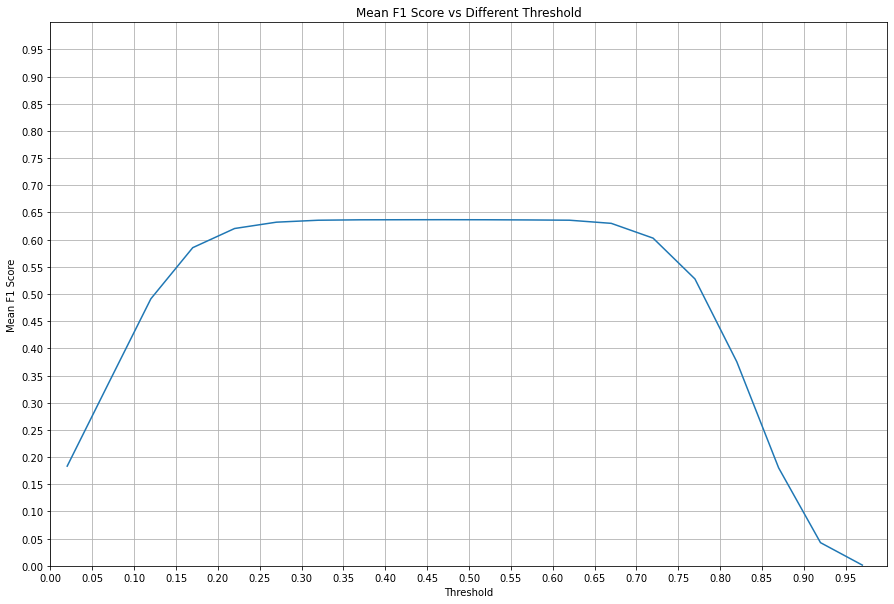

In [8]:
# drawing graph
from sklearn.metrics import fbeta_score
p_val = model.predict(X_val, batch_size=6000)
sample_f1=[]
threshold=np.arange(0.02,1,0.05)
for thr in threshold:
  sample_f1.append(fbeta_score(y_val, np.array(p_val) > thr, beta=1, average='samples'))

plt.plot(threshold,sample_f1)
plt.axis([0, 1, 0, 1])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15,10,forward=True)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10) 
my_x_ticks = np.arange(0, 1, 0.05) 
my_y_ticks = np.arange(0, 1, 0.05) 
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.grid()
plt.title('F1 Score vs Threshold for overall classes')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')

best_thr=threshold[np.argmax(sample_f1)]
text='Max F1-Score is %.4f when threshold at %.2f'
same_thr_f1=fbeta_score(y_val,np.array(p_val)>best_thr,beta=1, average='samples')
print(text%(same_thr_f1,best_thr))


### 4.2. Individual class F1 score under same threshold assigned

In [9]:
# Show each class f1-score
same_thr_f1_idv=fbeta_score(y_val,np.array(p_val)>best_thr,beta=1, average=None)

agn_thr=0.2
class_f1=fbeta_score(y_val, np.array(p_val) >agn_thr, beta=1, average=None)
count_label=[int(i) for i in ' '.join(labels).split()]
label_dic=list(set(count_label))
print('When threshold at: ',agn_thr)
print('\nLabel   F1-score at %.2f   F1-Score(best) at %.2f'%(agn_thr,best_thr))
for i in range(len(label_dic)):
  print(' ',label_dic[i],' '*8,round(class_f1[i],4),' '*15,np.round(same_thr_f1_idv[i],4))

When threshold at:  0.2

Label   F1-score at 0.20   F1-Score(best) at 0.47
  1          0.8622                 0.8622
  2          0.0                 0.0
  3          0.1961                 0.0
  4          0.0125                 0.0
  5          0.0534                 0.0
  6          0.0115                 0.0
  7          0.0                 0.0
  8          0.106                 0.0
  9          0.0246                 0.0
  10          0.0213                 0.0
  11          0.0                 0.0
  13          0.0105                 0.0
  14          0.0                 0.0
  15          0.0236                 0.0
  16          0.0521                 0.0
  17          0.0323                 0.0
  18          0.0357                 0.0
  19          0.0427                 0.0


### 4.3. Individual class F1 score with their best threshold and overall F1 score 

In [10]:
class_f1=[]
threshold=np.arange(0,1,0.05)
for thr in threshold:
  class_f1.append(fbeta_score(y_val, np.array(p_val) > thr, beta=1, average=None))

class_f1_T=np.transpose(class_f1)
p_val_T=np.transpose(p_val)
best_thr_list=[]
print('Label   Best Threshold   F1-Score')
p_val_T_logit=[]
for i in range(len(label_dic)):
  best_thr=threshold[np.argmax(class_f1_T[i])]
  print(' ',label_dic[i],' '*8,round(best_thr,2),' '*8,round(max(class_f1_T[i]),4))
  p_val_T_logit.append(p_val_T[i]>best_thr)
  best_thr_list.append(best_thr)

p_val_opt=np.transpose(p_val_T_logit)
print()
print('Mean(average="samples") F1-Score: ',fbeta_score(y_val,p_val_opt,beta=1,average='samples'))

Label   Best Threshold   F1-Score
  1          0.0          0.8622
  2          0.0          0.0723
  3          0.1          0.2873
  4          0.05          0.0912
  5          0.05          0.0938
  6          0.05          0.1016
  7          0.05          0.0997
  8          0.1          0.1583
  9          0.1          0.1036
  10          0.05          0.1158
  11          0.0          0.0395
  13          0.15          0.05
  14          0.05          0.0173
  15          0.05          0.1282
  16          0.15          0.0791
  17          0.05          0.1005
  18          0.05          0.1002
  19          0.1          0.0694

Mean(average="samples") F1-Score:  0.25828034537996813


### 4.4. Individual classes F1-Score vs threshold

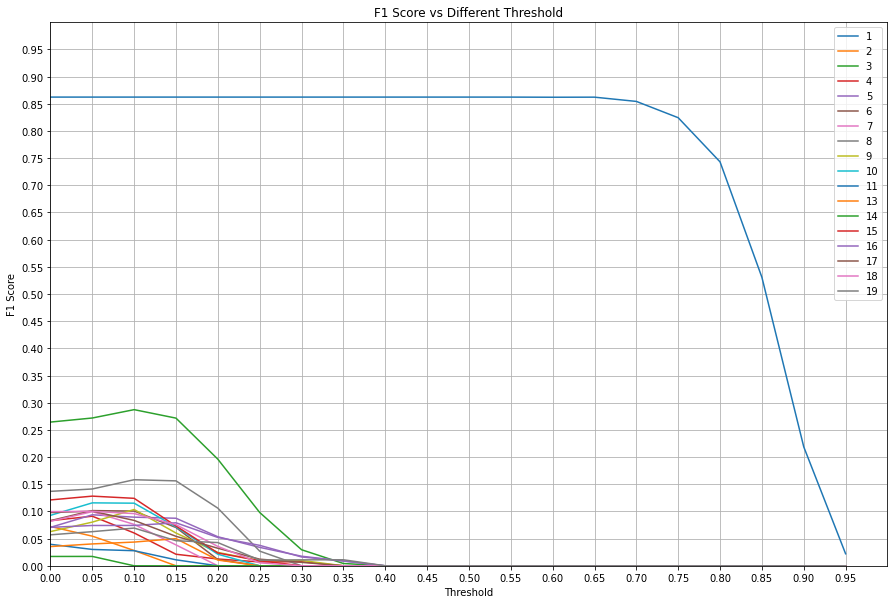

In [11]:
for i in range(len(label_dic)):
  plt.plot(threshold,class_f1_T[i],label=label_dic[i])

plt.axis([0, 1, 0, 1])
fig = matplotlib.pyplot.gcf()
fig.set_size_inches(15,10,forward=True)
plt.rc('xtick', labelsize=10)    # fontsize of the tick labels
plt.rc('ytick', labelsize=10) 
my_x_ticks = np.arange(0, 1, 0.05) 
my_y_ticks = np.arange(0, 1, 0.05) 
plt.xticks(my_x_ticks)
plt.yticks(my_y_ticks)
plt.grid()
plt.title('F1 Score vs Threshold for each class')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.legend()


### 4.5. Traverse different combination of threshold to find the best F1-Score

In [14]:
import itertools
thresh_list = np.arange(0,0.6,0.05)
category = 3


tune_result=[]
tune_list=[np.round(list(i),2) for i in itertools.product(*[thresh_list] * category)]

for p in tune_list:
  p_val_T_logit=[]
  p_val_opt=[]
  for i in range(18):
    if i==0:
      p_val_T_logit.append(p_val_T[i]>p[0])
    elif i==2:
      p_val_T_logit.append(p_val_T[i]>p[1])
    else:
      p_val_T_logit.append(p_val_T[i]>p[2])

  p_val_opt=np.transpose(p_val_T_logit)
  tune_result.append(fbeta_score(y_val,p_val_opt,beta=1,average='samples'))

print('Max F1-Score: ',max(tune_result))
print('\nAll combination of threshold:')
print('\nLabel:',label_dic[0],'Label:',label_dic[2],'Other labels')
tune_idx=np.where(tune_result==max(tune_result))
for i in tune_idx[0]:
  print(tune_list[i])

Max F1-Score:  0.6366892857142857

All combination of threshold:

Label: 1 Label: 3 Other labels
[0.   0.5  0.45]
[0.  0.5 0.5]
[0.   0.5  0.55]
[0.   0.55 0.45]
[0.   0.55 0.5 ]
[0.   0.55 0.55]
[0.05 0.5  0.45]
[0.05 0.5  0.5 ]
[0.05 0.5  0.55]
[0.05 0.55 0.45]
[0.05 0.55 0.5 ]
[0.05 0.55 0.55]
[0.1  0.5  0.45]
[0.1 0.5 0.5]
[0.1  0.5  0.55]
[0.1  0.55 0.45]
[0.1  0.55 0.5 ]
[0.1  0.55 0.55]
[0.15 0.5  0.45]
[0.15 0.5  0.5 ]
[0.15 0.5  0.55]
[0.15 0.55 0.45]
[0.15 0.55 0.5 ]
[0.15 0.55 0.55]
[0.2  0.5  0.45]
[0.2 0.5 0.5]
[0.2  0.5  0.55]
[0.2  0.55 0.45]
[0.2  0.55 0.5 ]
[0.2  0.55 0.55]
[0.25 0.5  0.45]
[0.25 0.5  0.5 ]
[0.25 0.5  0.55]
[0.25 0.55 0.45]
[0.25 0.55 0.5 ]
[0.25 0.55 0.55]
[0.3  0.5  0.45]
[0.3 0.5 0.5]
[0.3  0.5  0.55]
[0.3  0.55 0.45]
[0.3  0.55 0.5 ]
[0.3  0.55 0.55]
[0.35 0.5  0.45]
[0.35 0.5  0.5 ]
[0.35 0.5  0.55]
[0.35 0.55 0.45]
[0.35 0.55 0.5 ]
[0.35 0.55 0.55]
[0.4  0.5  0.45]
[0.4 0.5 0.5]
[0.4  0.5  0.55]
[0.4  0.55 0.45]
[0.4  0.55 0.5 ]
[0.4  0.55 0.55]
